In [17]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import ast
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary
import pickle

In [18]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from preproccessing import build_vocab, clean_text, tokenize_text, lemmatize_text, remove_stopwords

In [19]:
df= pd.read_csv('../data/Processed-Dataset.csv')
try:
    df['lemmatized_tokens']= df['lemmatized_tokens'].apply(ast.literal_eval)
    df['tokenized_reviews']= df['tokenized_reviews'].apply(ast.literal_eval)
    print("Sucessfully string back to lists")
except(ValueError,  SyntaxError) as e:
    print(f"Error converting column from string to list: {e}")


Sucessfully string back to lists


In [20]:
train_df, test_df= train_test_split(df, test_size= 0.2, random_state= 42, stratify= df['sentiment'])

In [21]:
train_df.to_csv('../data/train_dataframe.csv')

In [22]:
class TextSentimentDataset(Dataset):
    def __init__(self, lemmatized_tokens, labels, vocab, max_len):
        
        self.samples= list(zip(lemmatized_tokens, labels))
        
        self.vocab= vocab
        self.max_len= max_len

        self.pad_idx= vocab.get('<PAD>', 0)
        self.unk_idx= vocab.get('<UNK>', 1)
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        lemmatized_tokens, label= self.samples[idx]

        # 1. Numericalize the tokens and labels
        indexed_tokens= [
            self.vocab.get(token, self.unk_idx)
            for token in lemmatized_tokens
        ]
        # Keeping track of original length
        original_length= len(indexed_tokens)
        # If we're not gonna pad then original_length shouldn't be more than max_len
        if original_length > self.max_len:
            original_length= self.max_len

        numerical_labels= 0 if label == 'negative' else 1
        # 2. Pad or Truncate based on Max Length
        if len(indexed_tokens) > self.max_len:
            indexed_tokens= indexed_tokens[:self.max_len]
        else:
            padding_length= self.max_len - len(indexed_tokens)
            padding= [self.pad_idx] * padding_length
            indexed_tokens= indexed_tokens + padding
        # 3. Convert indeces & labels to PyTorch Tensor
        text_tensor= torch.tensor(indexed_tokens, dtype= torch.long)
        label_tensor= torch.tensor(numerical_labels, dtype= torch.long)
        
        return text_tensor, label_tensor, original_length

In [23]:
def collate_batch(batch):
    text_tensors, label_tensors, lengths= zip(*batch)

    lengths= torch.tensor(lengths, dtype= torch.long)
    sorted_lengths, sorted_indeces= lengths.sort(descending= True)
    
    sorted_text_tensors= torch.stack([text_tensors[i] for i in sorted_indeces])
    sorted_label_tensors= torch.stack([label_tensors[i] for i in sorted_indeces])

    return sorted_text_tensors, sorted_label_tensors, sorted_lengths

In [24]:
tokenized_lengths= df['lemmatized_tokens'].apply(lambda x: len(x))
tokenized_lengths.describe(percentiles= [0.7,0.75,0.8,0.85,0.9,0.95])

count    50000.000000
mean       129.523300
std         95.632529
min          4.000000
50%         97.000000
70%        140.000000
75%        157.000000
80%        179.000000
85%        208.000000
90%        253.000000
95%        330.000000
max       1491.000000
Name: lemmatized_tokens, dtype: float64

In [25]:
# Based on the distribution of lengths shown above i've elected to use the 80th percentile as my max sequence length
max_length= 179
vocab, idx_to_token= build_vocab(train_df, 'lemmatized_tokens', min_freq= 5)
train_dataset= TextSentimentDataset(lemmatized_tokens= train_df['lemmatized_tokens'],
                                    labels= train_df['sentiment'],
                                    vocab= vocab,
                                    max_len= max_length)
test_dataset= TextSentimentDataset(lemmatized_tokens= test_df['lemmatized_tokens'],
                                   labels= test_df['sentiment'],
                                   vocab= vocab,
                                   max_len= max_length)
text_tensor, label_tensor, lengths_tensor= train_dataset.__getitem__(15)
lengths_tensor

81

In [29]:
file_path= os.getcwd() + "/../artifacts/lstm_vocab.pkl"
file_path
try:
    os.makedirs(os.path.dirname(file_path), exist_ok= True)
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"Vocab successfully written to {file_path}")
except Exception as e:
    print(f"Error saving vocabulary {e}")


Vocab successfully written to /workspaces/pytorch-gpu-2/imdb-sentiment-analysis/Notebooks/../artifacts/lstm_vocab.pkl


In [139]:
len(vocab)

39468

In [12]:
class SimpleLSTM(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int):
        super().__init__()
        self.embedding= nn.Embedding(num_embeddings= vocab_size,embedding_dim= embedding_dim, padding_idx= 0)

        self.lstm= nn.LSTM(embedding_dim, hidden_size, batch_first= True)
        self.dropout= nn.Dropout(p= 0.5)
        self.fc= nn.Linear(hidden_size, 2)
    
    def forward(self, text_tensor: torch.Tensor, lengths: torch.Tensor):

        embedded= self.embedding(text_tensor)
    
        packed_embedded= nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(),
            batch_first= True, enforce_sorted= True
        )
        
        packed_output, (hidden_state, cell_state)= self.lstm(packed_embedded)


        final_hidden_state= hidden_state.squeeze(0)
        
        final_hidden_state= self.dropout(hidden_state)

        prediction= self.fc(final_hidden_state)

        return prediction

In [11]:
len(vocab)

39468

In [14]:
BATCH_SIZE= 64
VOCAB_SIZE= len(vocab)
EMBEDDING_DIM= 300
HIDDEN_SIZE= 512
train_dataloader= DataLoader(
    train_dataset,
    batch_size= BATCH_SIZE,
    collate_fn= collate_batch,
    shuffle= True
)
test_dataloader= DataLoader(
    test_dataset,
    batch_size= BATCH_SIZE,
    collate_fn= collate_batch,
    shuffle= False
)

device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

simple_lstm_1= SimpleLSTM(vocab_size= VOCAB_SIZE, embedding_dim= EMBEDDING_DIM, hidden_size= HIDDEN_SIZE).to(device)


optimizer= torch.optim.Adam(simple_lstm_1.parameters(), lr= 1e-4, weight_decay= 1e-4)
loss_fn= nn.CrossEntropyLoss()
text_tensor.shape
input_shape_text= (BATCH_SIZE, max_length)
input_shape_lengths= (BATCH_SIZE, )
text_tensor, label_tensor, lengths_tensor= next(iter(train_dataloader))
summary(simple_lstm_1, input_data= [text_tensor.to(device), lengths_tensor.to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 64, 2]                --
├─Embedding: 1-1                         [64, 179, 300]            11,840,400
├─LSTM: 1-2                              [7043, 512]               1,667,072
├─Dropout: 1-3                           [1, 64, 512]              --
├─Linear: 1-4                            [1, 64, 2]                1,026
Total params: 13,508,498
Trainable params: 13,508,498
Non-trainable params: 0
Total mult-adds (T): 6.01
Input size (MB): 0.09
Forward/backward pass size (MB): 56.34
Params size (MB): 54.03
Estimated Total Size (MB): 110.47

In [13]:
pred= simple_lstm_1(text_tensor.to(device), lengths_tensor.to(device))
# loss_fn(pred.to(device), label_tensor.to(device))
pred.shape

torch.Size([1, 64, 2])

In [14]:
train_losses= []
test_accuracies= []
train_accuracies= []
epochs= 5
for epoch in range(epochs):
    simple_lstm_1.train()
    running_loss= 0.0
    correct= 0
    total= 0
    for batch_idx, (X, y, lengths) in enumerate(train_dataloader):
        X, y= X.to(device), y.to(device)
        pred= simple_lstm_1(X, lengths)
        loss= loss_fn(pred.squeeze(0), y)
        optimizer.zero_grad()
        loss.backward()
        max_grad_norm= 1.0
        torch.nn.utils.clip_grad_norm(simple_lstm_1.parameters(), max_norm= max_grad_norm)

        # Gradient Diagnostics cuz model wasn't learning

        # if epoch < 2 and batch_idx < 5: # Inspect gradients for first 2 epochs, first 5 batches
        #      print(f"\n--- Gradients Check (Epoch {epoch+1}, Batch {batch_idx+1}) ---")
        #      for name, param in simple_lstm_1.named_parameters():
        #          if param.requires_grad: # Only check parameters we are training

        #              if param.grad is not None:
        #                  # Check for NaNs or Infs
        #                  if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
        #                       print(f"  !!! GRADIENT IS NaN/INF for {name} !!!")
        #                       # You might want to print param.grad itself or its stats here
        #                  else:
        #                      # Print magnitude of the gradient
        #                      # We check different layers to see gradient flow
        #                      if 'embedding' in name or 'rnn' in name or 'fc' in name:
        #                          grad_magnitude = param.grad.abs().max().item() # Or .mean().item()
        #                          print(f"  {name}: max_abs_grad = {grad_magnitude:.6f}")

        #              else:
        #                  print(f"  Warning: Gradient is None for {name}")
        
        optimizer.step()
        running_loss+= loss.item() * X.size(0)
        train_losses.append(running_loss / len(train_dataloader.dataset))

        correct+= (y==pred.squeeze(0).argmax(1)).sum().item()
        total+= y.size(0)
    train_accuracy= correct/total
    train_accuracies.append(train_accuracy)

    correct= 0
    total= 0
    val_loss= 0.0
    simple_lstm_1.eval()

    with torch.no_grad():
        for X, y, lengths in test_dataloader:
            X, y= X.to(device), y.to(device)
            pred= simple_lstm_1(X, lengths)
            correct+= (y==pred.squeeze(0).argmax(1)).sum().item()
            total+= y.size(0)
            val_loss+= loss_fn(pred.squeeze(0), y).item() * X.size(0)
            
        val_accuracy= correct/total
        val_loss/= len(test_dataloader.dataset)
        test_accuracies.append(val_accuracy)

    print(f"Epoch: {epoch + 1} | Train Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.2%} | Val_Accuracy: {val_accuracy:.2%} | Val_Loss: {val_loss:.4f}")
    

/tmp/ipykernel_56220/2884740863.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(simple_lstm_1.parameters(), max_norm= max_grad_norm)


Epoch: 1 | Train Loss: 0.5857 | Train Accuracy: 68.48% | Val_Accuracy: 78.70% | Val_Loss: 0.4541
Epoch: 2 | Train Loss: 0.4886 | Train Accuracy: 81.68% | Val_Accuracy: 81.14% | Val_Loss: 0.4158
Epoch: 3 | Train Loss: 0.3388 | Train Accuracy: 85.25% | Val_Accuracy: 85.07% | Val_Loss: 0.3567
Epoch: 4 | Train Loss: 0.4189 | Train Accuracy: 87.00% | Val_Accuracy: 85.64% | Val_Loss: 0.3354
Epoch: 5 | Train Loss: 0.2015 | Train Accuracy: 87.88% | Val_Accuracy: 86.11% | Val_Loss: 0.3368


In [15]:
torch.save(simple_lstm_1.state_dict(), '../models/simple_lstm.pth')

Text(0, 0.5, 'Accuracy')

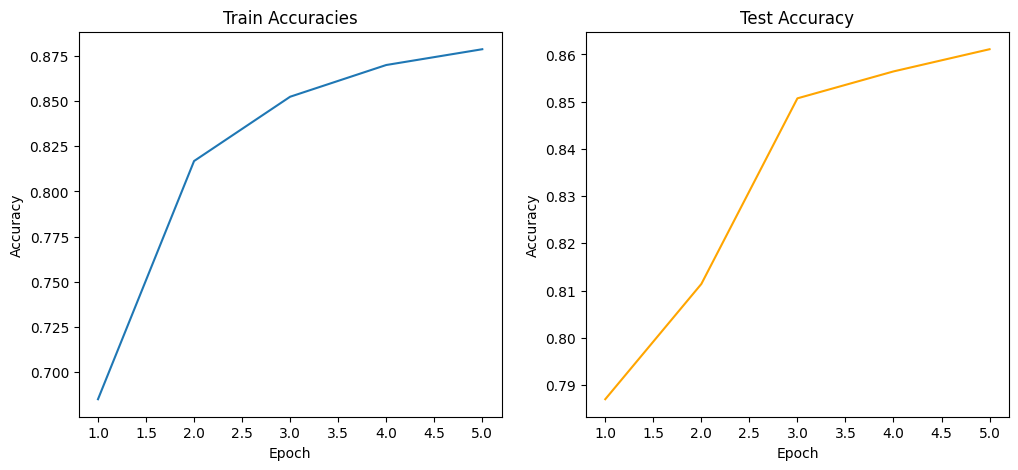

In [16]:
epochs= range(1, len(train_accuracies) + 1)
plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies)
plt.title("Train Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, test_accuracies, color= 'orange')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [141]:
loaded_lstm= SimpleLSTM(vocab_size= VOCAB_SIZE, embedding_dim= EMBEDDING_DIM, hidden_size= HIDDEN_SIZE)
loaded_lstm.load_state_dict(torch.load("../models/simple_lstm.pth"))
review= 'i am a huge rachel zegler defender but i draw the line at whatever that was'
review= clean_text(review)
review= remove_stopwords(review)
tokenized_review= tokenize_text(review)
lemmatized_review= lemmatize_text(tokenized_review)

indexed_tokens= [
            vocab.get(token, 1)
            for token in lemmatized_review
        ]

if len(indexed_tokens) > max_length:
    indexed_tokens= indexed_tokens[max_length]
else:
    padding_length= max_length - len(indexed_tokens)
    padding= [0] * padding_length
    indexed_tokens= indexed_tokens + padding

length= len(indexed_tokens)
index_tensor= torch.tensor(indexed_tokens, dtype= torch.long)
index_tensor= index_tensor.unsqueeze(0)
index_tensor.shape
length_tensor= torch.tensor([length], dtype= torch.long)
with torch.no_grad():
    pred= loaded_lstm(index_tensor, length_tensor)
sentiment= 'negative' if pred.squeeze().argmax(0) == 0 else 'positive'
sentiment, pred

('negative', tensor([[[ 3.9731, -4.2142]]]))

In [142]:
index_tensor

tensor([[  557,     1,     1, 13645,   793,   132,   911,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [143]:
lemmatized_review

['huge', 'rachel', 'zegler', 'defender', 'draw', 'line', 'whatever']